# Importing neccessary libs, tools, and packages

In [2]:
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord  
from astropy.coordinates import ICRS, Galactic, FK4, FK5 
from astropy.coordinates import Angle, Latitude, Longitude  
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import random

In [66]:
df = Table.read('../catalogs/Combined/main_update_with_errs.vot')
df

main_01_oid,main_non_rep_oid,source_id,Mass,Per,Rad,ra,dec,ruwe,reference,logAge,SpType,Lstar,rv_amplitude_robust,ipd_frac_multi_peak,parallax,pm,pmra,pmdec,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,ruwe_2,ruwe_f,ipd_f,rv_robust_old_bin,rv_amp_f,abs_Mag,reMass,parallax_error,pmra_error,pmdec_error,re_v_z,re_v_z_error,age_est
,,,solMass,d,solRad,deg,deg,,,[yr],,0.01 solLum,km / s,,mas,mas / yr,mas / yr,mas / yr,mag,mag,km / s,km / s,,,,,,,,mas,mas / yr,mas / yr,,,
int32,int32,int64,float32,float64,float32,float64,float64,float64,object,float32,str6,float32,float32,int16,float64,float32,float64,float64,float32,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64
1,1,2859027409595355776,0.26,1.08,0.27,6.14834,30.04158,1.298,Newton17,--,,--,22.453743,0,51.316075949778615,585.9754,585.8907544586369,9.959853297532621,12.960726,3.1202898,10.285248,1.3245473,1.2977159,0,0,1,0,11.511992980482372,0.21,0.042310424,0.050504275,0.03205134,5.983532360040597,0.6695734060013798,0.13691022524370997
2,2,416158489625704320,0.42,52.82,0.43,8.97791,52.68592,1.382,Newton17,--,,--,3.9425075,2,41.170241007502874,798.139,777.168600019981,-181.75470165920962,11.530065,2.390316,-0.6372399,0.21027899,1.3819181,0,1,1,0,9.602981629485956,0.41,0.03242564,0.02499476,0.02480002,-13.196624983655905,0.16647627142719598,0.5242877912384664
3,3,2779735823615714176,0.3,34.01,0.32,9.89131,14.90545,1.462,Newton17,--,,--,14.191612,0,34.81687111605054,333.7426,331.9076871660051,34.94894273834515,12.900315,2.784772,3.5010433,0.75865865,1.4623499,1,0,1,0,10.609263983929928,0.3,0.031152343,0.033893805,0.02495529,5.501656979023917,0.19137050236109474,0.12580434056633444
4,4,2779735819320035840,0.33,1.59,0.34,9.89231,14.90984,9.76,Newton17,--,,--,37.42855,0,34.257941698203155,328.88693,327.53892627570303,29.746753158291376,12.961825,3.0671816,4.04884,1.9026254,9.759859,1,0,1,0,10.635631700426684,0.3,0.21735539,0.24737093,0.21139015,5.029282852510507,0.49381077534820517,0.10492446867337922
5,9,218366758786141440,0.64,13.56,0.64,56.13003,34.97243,1.149,Newton17,--,,--,1.6434832,0,38.91906820720074,254.26979,199.2893730472693,-157.91413154558745,9.984372,1.8008165,4.228812,0.16059309,1.1490544,0,0,1,0,7.93518430860877,0.6,0.018363647,0.019009233,0.014616211,-13.336068192955032,0.09322751298395983,0.533851205134233
6,10,476809509515283712,0.18,1.59,0.2,63.07603,64.73018,1.105,Newton17,--,,--,6.8997974,1,82.90278034597667,657.84863,492.7870898317532,-435.8046816667496,12.211264,3.003995,20.027607,0.3189078,1.1049324,0,0,1,0,11.804109136187071,0.2,0.020169007,0.012978728,0.018591693,7.472810511953686,0.29144978906042124,0.20659170156692322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,1802,1022456104850892928,0.58,16.88,0.58,138.60285,52.68636,1.118,Shan,--,M0.0 V,7.55,0.8336086,0,157.8824911260602,1705.8522,-1573.0402244550992,-659.9060008123529,7.054455,1.8464499,11.969568,0.122066654,1.118406,0,0,1,0,8.04612465461796,0.59,0.021135049,0.017991045,0.018531306,-2.493750411684773,0.10104196575388814,0.03531536481376473


# Monte Carlo Simulations to Calculate Vertical Velocity aka Velocity Dispersion from galactic disk


In [14]:
ra = np.array(df['ra'])
dec = np.array(df['dec'])

parallax = np.array(df['parallax'])
parallax_error = np.array(df['parallax_error'])

pmra = np.array(df['pmra'])
pmra_error = np.array(df['pmra_error'])

pmdec = np.array(df['pmdec'])
pmdec_error = np.array(df['pmdec_error'])

r_v = np.array(df['radial_velocity'])
r_v_error = np.array(df['radial_velocity_error'])

v_z_dist = []
v_z = []
v_z_error = []

for i in range(len(df)): 
    pmra_dist = np.random.normal(pmra[i], pmra_error[i], 2000)
    pmdec_dist = np.random.normal(pmdec[i], pmdec_error[i], 2000)    
    parallax_dist = np.random.normal(parallax[i], parallax_error[i], 2000)    
    rv_dist = np.random.normal(r_v[i], r_v_error[i], 2000)
    
    C = SkyCoord(
        ra = ra[i] * u.degree, 
        dec = dec[i] * u.degree,
        distance = (1e3/parallax_dist * u.pc),
        pm_ra_cosdec = pmra_dist * u.mas/u.yr,
        pm_dec = pmdec_dist * u.mas/u.yr,
        radial_velocity = rv_dist * u.km/u.s,
        frame = 'icrs')
    v_z_dist = C.velocity.d_z/(u.km/u.s)
    v_z.append(np.nanmedian(v_z_dist))
    v_z_error.append(np.nanstd(v_z_dist))

/Users/nular/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
<__array_function__ internals>:200: RuntimeWarning: Degrees of freedom <= 0 for slice.


In [15]:
v_z

[<Quantity 5.98353236>,
 <Quantity -13.19662498>,
 <Quantity 5.50165698>,
 <Quantity 5.02928285>,
 <Quantity -13.33606819>,
 <Quantity 7.47281051>,
 <Quantity -13.7700238>,
 <Quantity -12.32612273>,
 <Quantity 13.65646451>,
 <Quantity -8.27525032>,
 <Quantity nan>,
 <Quantity -19.55025716>,
 <Quantity -33.42745233>,
 <Quantity -72.56392981>,
 <Quantity -18.97113885>,
 <Quantity 0.25343556>,
 <Quantity -4.81206147>,
 <Quantity 31.38722068>,
 <Quantity -94.29076793>,
 <Quantity -40.89178367>,
 <Quantity 58.20963528>,
 <Quantity -2.22118973>,
 <Quantity -12.29556443>,
 <Quantity -15.61261495>,
 <Quantity 14.50698629>,
 <Quantity 15.25231045>,
 <Quantity -17.98479521>,
 <Quantity -8.37822159>,
 <Quantity -4.60632903>,
 <Quantity -29.17780595>,
 <Quantity 0.80551783>,
 <Quantity 9.81452954>,
 <Quantity -16.11348645>,
 <Quantity 21.36996637>,
 <Quantity -30.23240818>,
 <Quantity -20.45829172>,
 <Quantity -7.98589171>,
 <Quantity 6.21782058>,
 <Quantity 9.56318657>,
 <Quantity -7.06055223>,
 

# Distributions

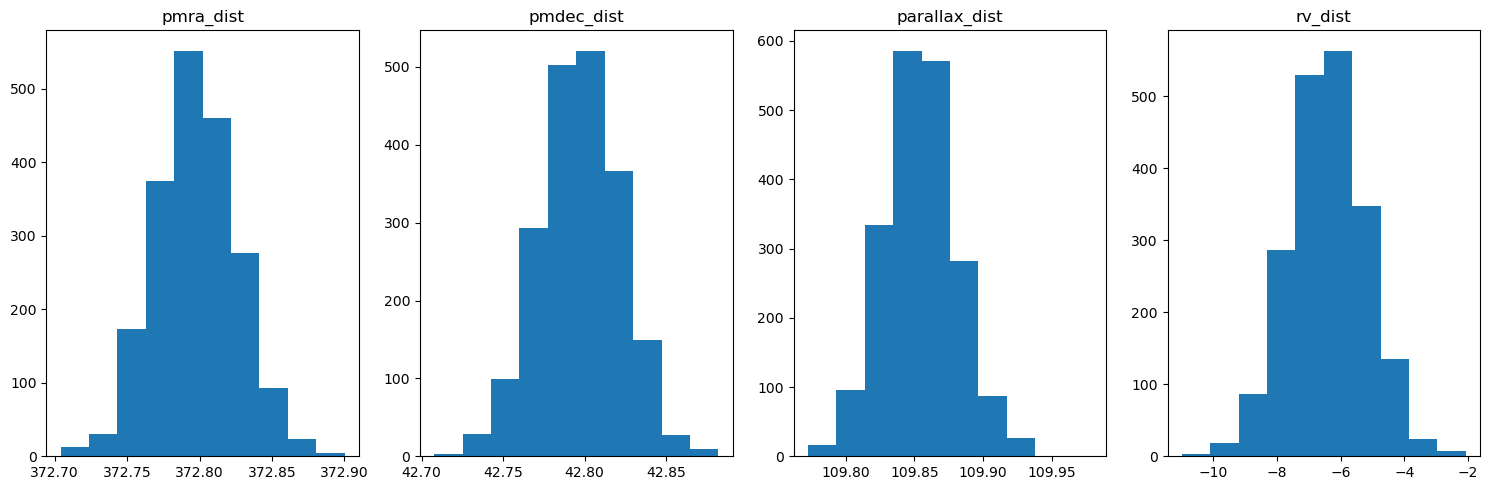

In [18]:
fig,ax = plt.subplots(1, 4, tight_layout = True, figsize = (15,5))
list = [pmra_dist, pmdec_dist, parallax_dist, rv_dist]
labels = ['pmra_dist', 'pmdec_dist', 'parallax_dist', 'rv_dist']
bins = 10

for i in range(len(list)):
    ax[i].hist(list[i], bins)
    ax[i].set_title(labels[i])

Text(0.5, 0, 'v_z_error')

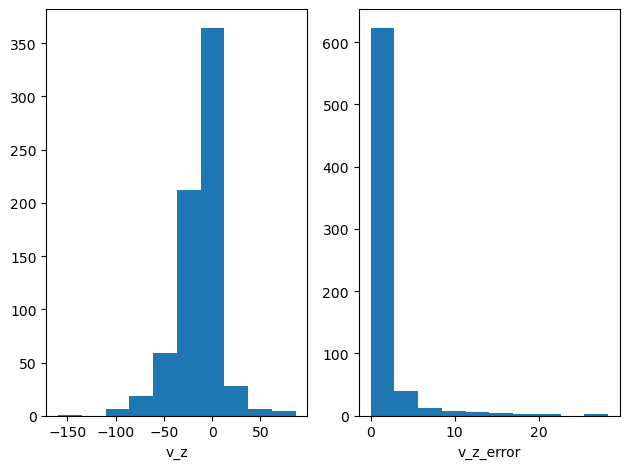

In [20]:
fig, ax = plt.subplots(1, 2, tight_layout = True)
ax[0].hist(v_z)
ax[0].set_xlabel('v_z')
ax[1].hist(v_z_error, label = 'error')
ax[1].set_xlabel('v_z_error')

In [26]:
df.add_column(col = v_z, name = 're_v_z')
df.add_column(col = v_z_error, name = 're_v_z_error')
# df.write('../catalogs/Combined/main_update_with_errs.vot', format= 'votable', overwrite= True)

In [30]:
def get_idx_sample(posterior_grid):
    idx_list = np.arange(0, len(posterior_grid))
    sample_idx = np.array(random.choices(idx_list,
                                         posterior_grid, k=262144))
    return sample_idx

## Using mdwarfdate, which uses Bayesian Inference on relations between vertical velocity, its error range, and mass to calculate the least possible [**Lower Limit**] age for stars

In [32]:
lower_lim_age = []
cols = 4
rows = int(len(df)/cols) + 1
n_bad = []

v_z = df['re_v_z']
v_z_error = df['re_v_z_error']
delta = 0.005

for i in range(len(df)):
    if abs(v_z[i]) > 0:
        
        log_t = np.linspace(np.log(0.01),np.log(13.8),10000)
        variance = (np.exp(0.54 * log_t + 1.90))**2 + v_z_error[i]**2
        model_vz = 0
        lnlike = -(v_z[i] - model_vz)**2/(2 * (variance)) - 0.5 * np.log(2*np.pi*(variance))
        lnprior = log_t
        
        exp_posterior = np.exp(lnlike + lnprior)
        posterior = exp_posterior / np.nansum(exp_posterior)
        
        max_posterior = np.max(posterior)
        max_posterior_idx = np.argmax(posterior)
        lower_limit_age = np.min(log_t[posterior > max_posterior*delta])
        log10_lower_limit_age_yr = np.log10(np.exp(lower_limit_age)*1e9)
        lower_limit_age_Gyr = np.exp(lower_limit_age)
        
        mask = posterior > max_posterior * delta
        log10_age_yr = np.log10(np.exp(log_t)*1e9)
        age_Gyr = np.exp(log_t)
    
        
        idx_sample = get_idx_sample(posterior)
        log10_median_yr = np.median(log10_age_yr[idx_sample])
        
        median_gyr = np.median(age_Gyr[idx_sample])
        err_low = median_gyr - np.percentile(age_Gyr[idx_sample],16)
        err_high = np.percentile(age_Gyr[idx_sample],84) - median_gyr
    
        lower_lim_age.append(lower_limit_age_Gyr)
        
    else:
        lower_lim_age.append(np.nan)
        n_bad.append(v_z[i])

lower_lim_age = np.array(lower_lim_age)
lower_lim_age, n_bad

(array([1.36910225e-01, 5.24287791e-01, 1.25804341e-01, 1.04924469e-01,
        5.33851205e-01, 2.06591702e-01, 5.61973192e-01, 4.65661763e-01,
        5.54305556e-01, 2.45385823e-01,            nan, 9.87044292e-01,
        2.25070541e+00, 6.08268333e+00, 9.40366930e-01, 1.00000000e-02,
        1.01638894e-01, 2.04582323e+00, 7.76665000e+00, 3.00774074e+00,
        4.75695061e+00, 2.85730130e-02, 4.49777422e-01, 6.88580984e-01,
        5.98460207e-01, 6.63171754e-01, 8.64086238e-01, 2.50585553e-01,
        3.40860558e-02, 1.83953166e+00, 1.00000000e-02, 3.19959166e-01,
        7.23806297e-01, 1.13650253e+00, 1.94063874e+00, 1.06105665e+00,
        2.31594331e-01, 1.54035574e-01, 3.10837769e-01, 1.89285147e-01,
        1.74117250e+00, 1.50021610e+00, 1.68606163e-01, 5.82661824e-01,
        1.00000000e-02, 1.85829453e-02, 8.76672684e-01, 2.27695252e-02,
        1.54481725e-01, 3.66410298e+00, 2.00632182e-02, 6.02157290e-02,
        1.01087924e+00, 4.31305038e-01, 2.70647856e-02, 1.484032

In [62]:
df.add_column(col = lower_lim_age, name = 'age_est')
# df.write('../catalogs/Combined/main_update_with_errs.vot', format = 'votable', overwrite= True)

In [64]:
np.nanmin(df['age_est']), np.nanmax(df['age_est'])

(0.010000000000000005, 10.745543953612636)

Text(0.5, 1.0, 'estimated_age distribution')

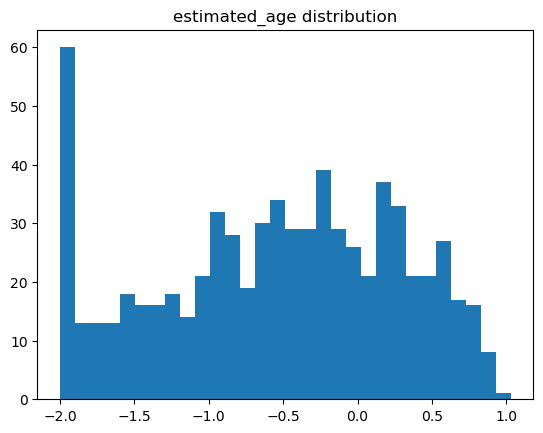

In [36]:
plt.hist(np.log10(lower_lim_age), bins = 30)
plt.title('estimated_age distribution')

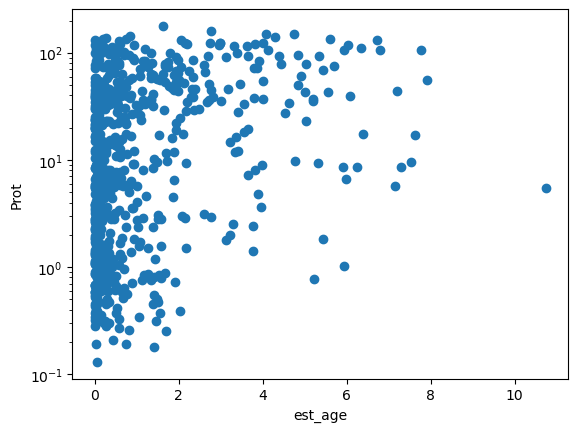

In [38]:
plt.scatter(lower_lim_age, df['Per'])
plt.yscale('log')
plt.xlabel('est_age')
plt.ylabel('Prot')
plt.show()

In [44]:
mask1 = df['ruwe_f'] == 1
mask2 = df['ipd_f'] == 1
mask3 = df['rv_amp_f'] == 1

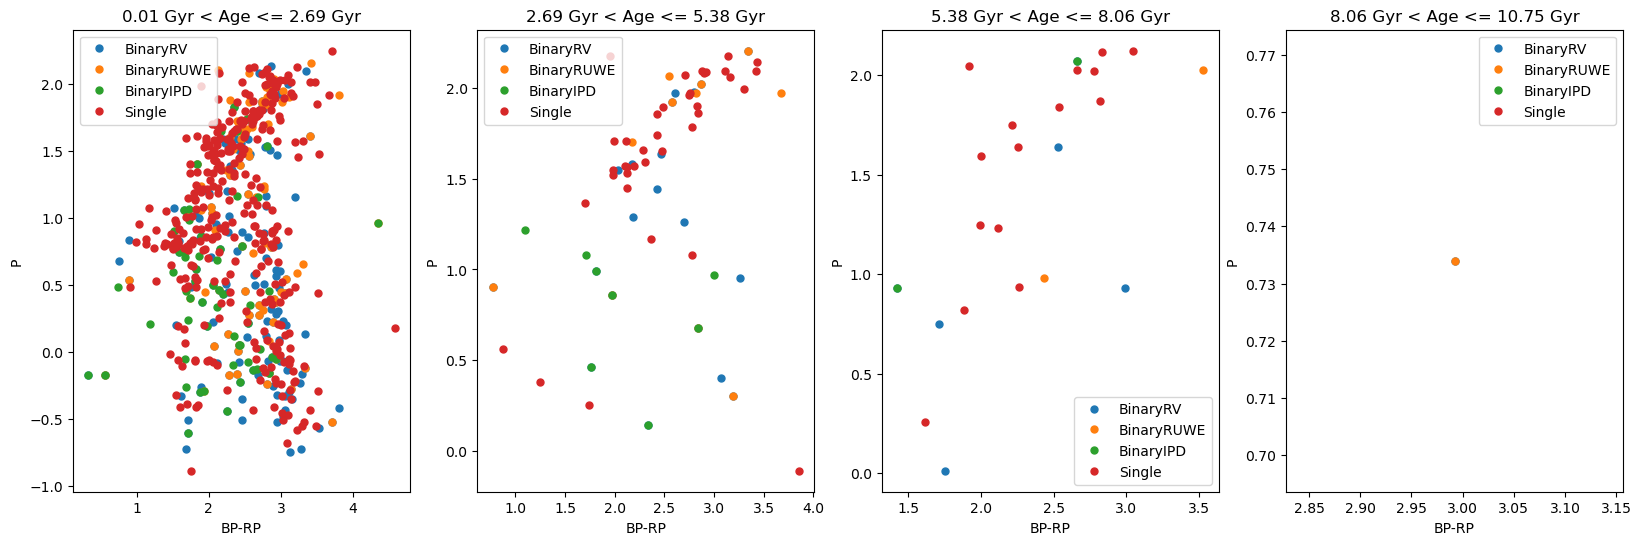

In [68]:
mask_nonbinary = df['ruwe_f'] + df['ipd_f'] + df['rv_amp_f'] == 0

age_range = np.linspace(np.nanmin(df['age_est']), np.nanmax(df['age_est']), num = 5)

x = df['bp_rp']
y= np.log10(df['Per'])

fig, axs = plt.subplots(1, 4, figsize=(20,6))
axs = axs.ravel()

for i in range(len(age_range)-1):
    mask = (age_range[i] < df['age_est']) * (df['age_est'] <= age_range[i+1])
    
    axs[i].set_ylabel('P')
    axs[i].set_ylabel('P')
    axs[i].set_xlabel('BP-RP')
    axs[i].set_xlabel('BP-RP')

    axs[i].plot(x[mask1 & mask],y[mask1 & mask],'o', markersize = 5, label = 'BinaryRV')
    axs[i].plot(x[mask2 & mask],y[mask2 & mask],'o', markersize = 5, label = 'BinaryRUWE')
    axs[i].plot(x[mask3 & mask],y[mask3 & mask],'o', markersize = 5, label = 'BinaryIPD')

    axs[i].plot(x[mask_nonbinary & mask],y[mask_nonbinary & mask],'o',markersize = 5, label = 'Single')
    axs[i].set_title(f'{np.round(age_range[i], 2)} Gyr < Age <= {np.round(age_range[i+1], 2)} Gyr')
    axs[i].legend()

plt.show()